<a href="https://colab.research.google.com/github/Shriharsh7/Food_Vision_101/blob/main/EffNet_PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## 0. Get Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3824, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 3824 (delta 245), reused 399 (delta 196), pack-reused 3357
Receiving objects: 100% (3824/3824), 650.71 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (2201/2201), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting the data
The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 Questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?
FoodVision Mini ideal use case: A model that performs well and fast.

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

* EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)

* ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor
Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [ ]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 43.3MB/s]


In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

### 3.1 Creating a function to get EfficientNetB2 Feature Extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)


In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

### 3.2 Creating dataloaders for EffNetb2

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 Feature Extractor

In [ ]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


In [ ]:
!nvidia-smi

Thu Jun 15 08:28:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    38W /  70W |   2091MiB / 15360MiB |     59%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3.4 Inspecting EffNetB2 loss curves

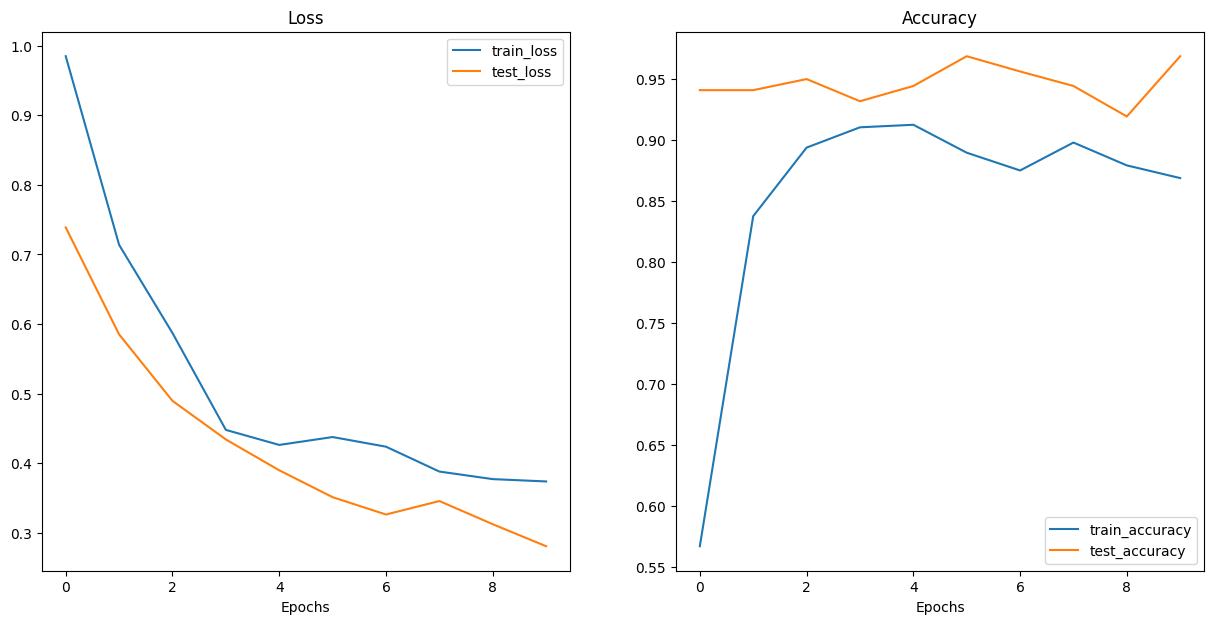

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5 Saving our EffNetB2 mmodel

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor
Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.



In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats


{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor
We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [ ]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads


Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):

  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 52.3MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from torchinfo import summary

# Print ViT model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor
We're up to model experiment number two: a ViT feature extractor.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

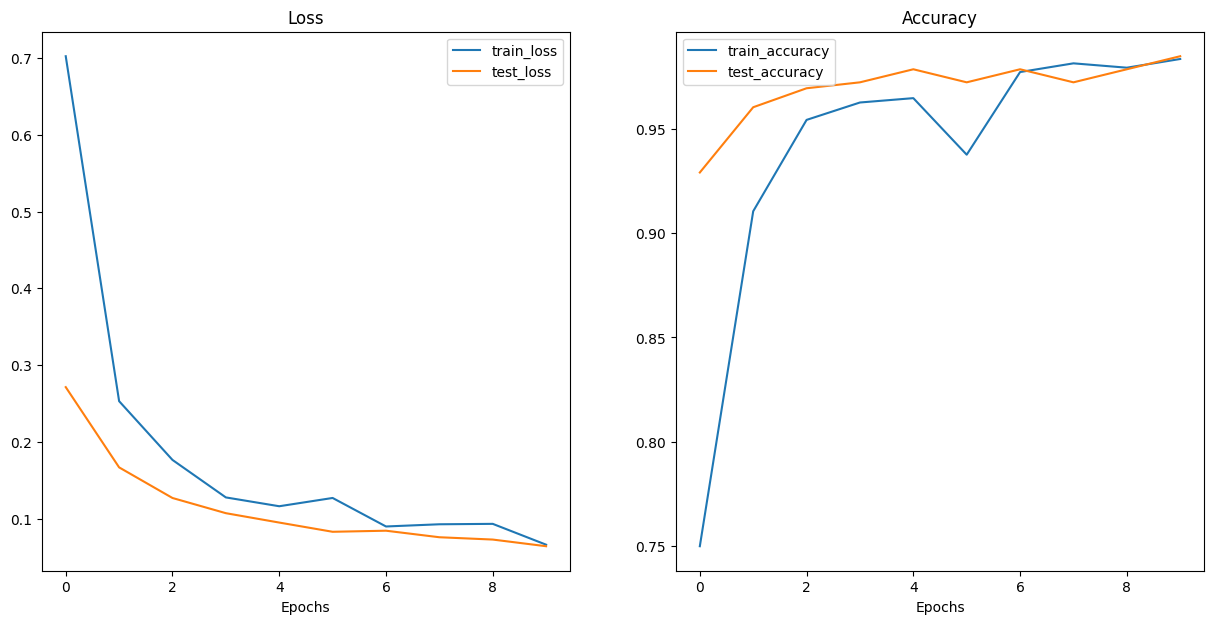

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [ ]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327.37038707733154 MB


### 4.6 Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params


85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418212624266743,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained models and timing them
Our goal:

* Performs well (95%+ test accuracy)
* Fast (30+FPS)

To test criteria two:

1. Loop through test images
2. Time how long each model takes to make a prediction on the image
3. Let's work towards making a function called pred_and_store() to do so.

First we'll need a list of test image paths.

In [ ]:
from pathlib import Path
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg')]

### 5. Creating a fn to make predictions across the test dataset

Steps to create pred_and_store():

* Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
* Create an empty list (can return a full list of all predictions later).
* Loop through the target input paths (the rest of the steps will take place inside the loop).
* Create an empty dictionary for each sample (prediction statistics will go in here).
* Get the sample path and ground truth class from the filepath.
* Start the prediction timer.
* Open the image using PIL.Image.open(path).
* Transform the image to be usable with a given model.
* Prepare the model model for inference by sending to the target device and turning on eval() mode.
* Turn on torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
* Add the pred prob + pred class to empty dictionary from step 4.
* End the prediction timer started in step 6 and add the time to the prediction dictionary.
* See if the predicted class matches the ground truth class.
* Append the updated prediction dictionary to the empty list of predictions we created in step 2.
* Return the list of prediction dictionaries.


In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer # https://docs.python.org/3/library/timeit.html#timeit.default_timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer.
    start_time = timer()

    # 7. Open the image using Image.open(path)
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device)
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into predicition probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries.
  return pred_list

### 5.2 Making and timing predictions with EffNetB2
Let's test our pred_and_store() function.

Two things to note:

1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g.
EffNetB2 with effnetb2_transforms)


In [ ]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:3]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9558,
  'pred_class': 'pizza',
  'time_for_pred': 0.2835,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8771,
  'pred_class': 'pizza',
  'time_for_pred': 0.1192,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8501,
  'pred_class': 'pizza',
  'time_for_pred': 0.1133,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9558,pizza,0.2835,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8771,pizza,0.1192,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8501,pizza,0.1133,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8149,pizza,0.1147,True
4,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.6186,pizza,0.0969,True


In [ ]:

# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")


EffNetB2 average time per prediction: 0.1105


In [ ]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats


{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.1105}

### 5.3 Making and timing predictions with ViT


In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9979,
  'pred_class': 'pizza',
  'time_for_pred': 0.5583,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9982,
  'pred_class': 'pizza',
  'time_for_pred': 0.417,
  'correct': True}]

In [ ]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9979,pizza,0.5583,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9982,pizza,0.4170,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,0.4045,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9986,pizza,0.4141,True
4,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9853,pizza,0.4298,True


In [ ]:
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")


ViT average time per prediction: 0.4291


In [ ]:

# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418212624266743,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.4291}

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29.863233,0.1105,EffNetB2
1,0.064182,98.47,85800963,327.370387,0.4291,ViT


Which model is better?

* test_loss (lower is better) - ViT
* test_acc (higher is better) - ViT
* number_of_parameters (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * sometimes models with higher parameters can still perform fast
* model_size (MB) - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* time_per_pred_cpu (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.




In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,10.962323,3.883258


### 6.1 Visualizing the speed vs. performance tradeoff
So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:

1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (model_size (MB)).

In [ ]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29.863233,0.1105,EffNetB2
1,0.064182,98.47,85800963,327.370387,0.4291,ViT


In [ ]:

import matplotlib
matplotlib.__version__

'3.7.1'

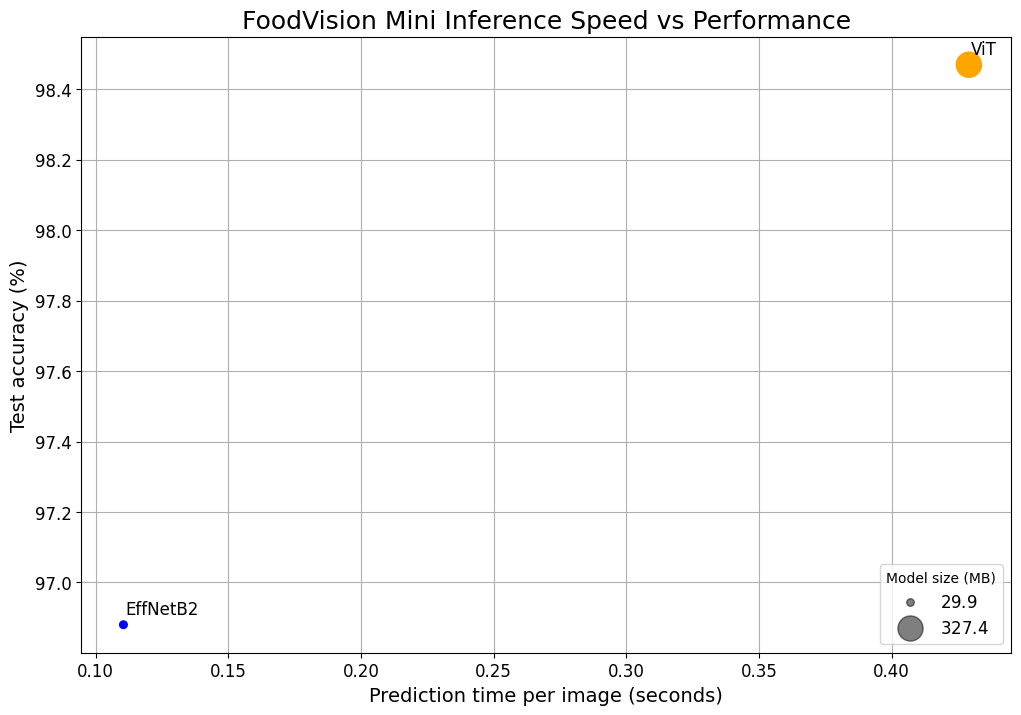

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(text=row["model"], # note: in some versions of Matplotlib, this may need to be "text" rather than "s"
              xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
              size=12)

# 4. Create a legend based on the model sizes (model_size (MB)).
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")


## 7. Bringing FoodVision Mini to life by creating a Gradio demo
We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?

Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://gradio.app/

For FoodVision Mini, we're going to be working towards building something like this: https://huggingface.co/spaces/mrdbourke/foodvision_mini

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:0

### 7.1 Gradio overview
Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs and outputs

In [ ]:

# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device


device(type='cpu')

Let's create a function called predict() to go from:

images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time


In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg

{'pizza': 0.9562608599662781, 'steak': 0.036752961575984955, 'sushi': 0.006986172869801521}
0.1091


### 7.3 Creating a list of example images
The examples for Gradio can be created with the examples parameter, see here: https://gradio.app/docs/#building-demos

In [ ]:

# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg']]

### 7.4 Building a Gradio Interface

Let's use gr.Interface() to go from:

input: image -> transform -> predict with EffNetB2 -> output: pred, prob prob, time

In [ ]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://174122f7948c760e9e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app
Our Gradio demos from Google Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces: https://huggingface.co/docs/hub/spaces

### 8.1 What is Hugging Face Spaces?
Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built).

### 8.2 Deployed Gradio app structure
Let's start to put all of our app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Why use this structure?

Because it's one of the simplest we could start with.

You can see this in action:

Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
See the example file structure - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3 Creating a demos folder to store our FoodVision app files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo
What we want:

* 3 images in an examples/ directory
* Images should be from the test set

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)


[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our examples/ directory.



In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory


In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the movel
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a Python script `model.py`
We have a saved .pth model state_dict and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:

class_names

['pizza', 'steak', 'sushi']

### 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)
The app.py file will have four major parts:

1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (predict())
4. Gradio app - our Gradio interface + launch command

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms perparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)
The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:

* torch
* torchvision
* gradio


In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.0.1+cu118
0.15.2+cu118
3.34.0


In [ ]:

%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.34.0


Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app HuggingFace Spaces
There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

1. Uploading via the Hugging Face Web interface (easiest).
2. Uploading via the command line or terminal.
* Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

### 9.1 Downloading our FoodVision Mini app files
We want to download our foodvision_mini demo app so we can upload it to Hugging Face Spaces.

In [ ]:
!ls demos/foodvision_mini/examples

2582289.jpg  3622237.jpg  592799.jpg


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo app locally
Running the app locally - https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces
See the steps here - https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

See the live app deployed here - https://huggingface.co/spaces/mrdbourke/foodvision_mini_video

We can also share our app by embedding it: https://gradio.app/sharing_your_app/#embedding-hosted-spaces

## 10. Food Vision Big 101

In [ ]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)


In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:

# Create training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 images x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # apply data augmentation to training data
                              download=True)

# Get the testing data (~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [00:57<00:00, 86382161.87it/s] 


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

10.3 Creating a subset of the Food101 dataset for faster experimenting
Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this the is first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [ ]:
len(train_data), len(test_data)

(75750, 25250)

In [ ]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=1,
                  seed:int=42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # defaults to 100% data split
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2


In [ ]:
# Create training 95% split Food101
train_data_food101, _ = split_dataset(dataset=train_data,
                                                 split_size=1)

# Create testing 95% split Food101
test_data_food101, _ = split_dataset(dataset=test_data,
                                                split_size=1)

[INFO] Splitting dataset of length 75750 into splits of size: 75750 and 0
[INFO] Splitting dataset of length 25250 into splits of size: 25250 and 0


In [ ]:

len(train_data_food101), len(test_data_food101)

(75750, 25250)

### 10.4 Turning our datasets into dataloaders

In [ ]:
import os

os.cpu_count()

2

In [ ]:
import os
import torch

NUM_WORKERS = 2 # this value is very experimental and the best value will differ depeneding on the hardware you're using, search "pytorch num workers setting for more"
BATCH_SIZE = 32

# Create Food101 20% training DataLoader
train_dataloader_food101 = torch.utils.data.DataLoader(dataset=train_data_food101,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101 = torch.utils.data.DataLoader(dataset=test_data_food101,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)


In [ ]:
len(train_dataloader_food101), len(test_dataloader_food101)

(2368, 790)

In [ ]:
790 * 32

25280

### 10.5 Training FoodVision Big!!!!
Things for training:

5 epochs
* Optimizer: torch.optim.Adam(lr=1e-3)
* Loss function: torch.nn.CrossEntropyLoss(label_smoothing=0.1)
Why use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:

[0.00, 0.00, 0.99, 0.01, 0.00]

With label smoothing and 5 classes:
[0.01, 0.01, 0.96, 0.01, 0.01]

  * Note: Depending on your hardware, running the following cell may take 15-20 minutes (takes about 17 minutes on a NVIDIA Tesla P100 GPU).

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9824 | train_acc: 0.4060 | test_loss: 2.1882 | test_acc: 0.6085
Epoch: 2 | train_loss: 2.6549 | train_acc: 0.4797 | test_loss: 2.1046 | test_acc: 0.6310
Epoch: 3 | train_loss: 2.6128 | train_acc: 0.4899 | test_loss: 2.0741 | test_acc: 0.6357
Epoch: 4 | train_loss: 2.5934 | train_acc: 0.4965 | test_loss: 2.0544 | test_acc: 0.6423
Epoch: 5 | train_loss: 2.5941 | train_acc: 0.4975 | test_loss: 2.0560 | test_acc: 0.6429


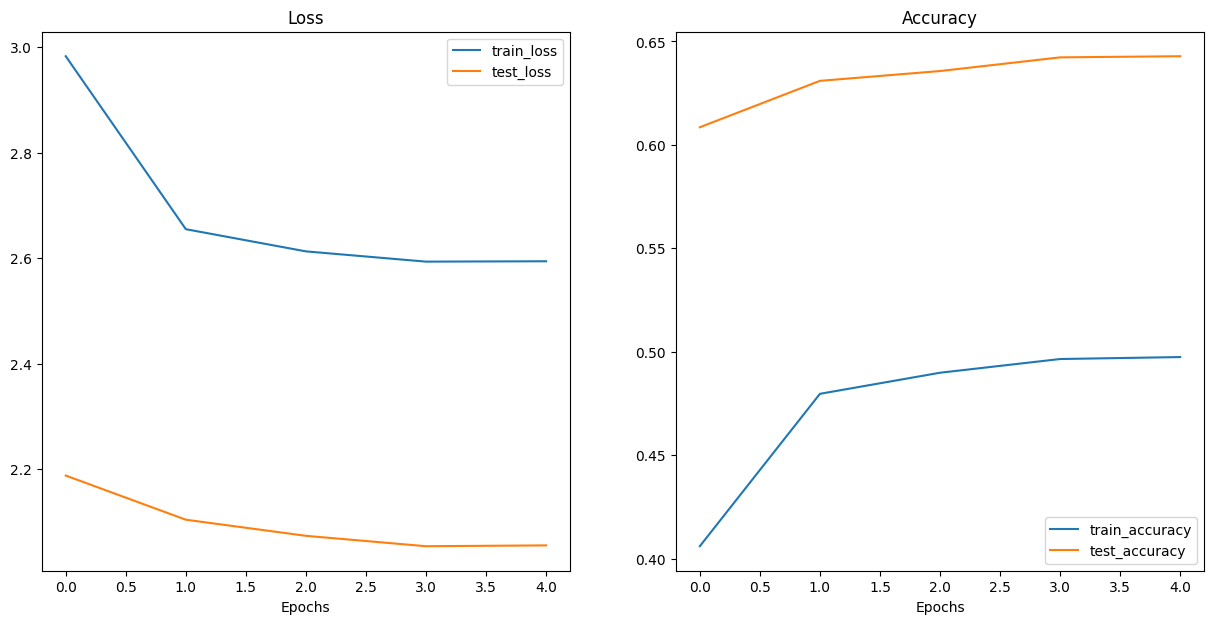

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101.pth


In [ ]:

# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101.pth"))

<All keys matched successfully>

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")


Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


11. Turning our FoodVision Big model into a deployable app
Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set).

Let's create an outline for our FoodVision Big app:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt

```


In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [ ]:
!ls demos/foodvision_big

examples


In [ ]:
# Download and move example image
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg


--2023-06-15 10:37:11--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2023-06-15 10:37:11--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.02s   

2023-06-15 10:37:11 (116 MB/s) - ‘04-pizza-dad.jpeg’ saved [

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101.pth demos/foodvision_big/


### 11.2 Saving Food101 class names to file (class_names.txt)

Let's save all of the Food101 class names to a .txt file so we can import them and use them in our app.

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [ ]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name


[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:

# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)
The app.py file will have four major parts:

* Imports and class names setup - for class names, we'll need to import from class_names.txt rather than with a Python list
* Model and transforms preparation - we'll need to make sure our model is suitable for FoodVision Big
* Predict function (predict()) - this can stay the same as the original predict()
* Gradio app - our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location=torch.device("cpu")) # load to CPU
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision BIG 🍔👁💪"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_big/app.py


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### 11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [ ]:

# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_food101.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [ ]:

# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big model app to Hugging Faces Spaces
Let's bring FoodVision Big to life by deploying it to the world!!!

See steps here: https://www.learnpytorch.io/09_pytorch_model_deployment/#117-deploying-our-foodvision-big-app-to-huggingface-spaces

See our deployed app here: https://huggingface.co/spaces/mrdbourke/foodvision_big_video